# Influence of floating point precision on drift-diffusion simulation

This notebooks runs simple calculation with double (64 bit) and extended (80 bit) precision. In both cases concentration is correctly calculated, however, arithmetic errors are visible in the conservation of current. The problem can be resolved by increasing minimum mesh spacing.

In [1]:
from oedes import *
%matplotlib inline
import matplotlib.pylab as plt

In [2]:
b = models.BaseModel()
models.electronic_device(b, fvm.mesh1d(100e-9, dx_boundary=1e-11), 'p')

b.setUp()

In [3]:
b.species[0].convergenceTest = fvm.ElementwiseConvergenceTest(
    rtol=1e-12, atol=0)

In [4]:
params = {
    'T': 300,
    'electrode0.voltage': 1e-3,
    'electrode0.workfunction': 0,
    'electrode1.voltage': 0,
    'electrode1.workfunction': -1,
    'hole.mu': 1e-9,
    'hole.N0': 1e27,
    'hole.level': 0,
    'epsilon_r': 3}

In [5]:
typename = {np.double: 'double', np.float128: 'extended'}
types = [np.double, np.float128]

In [6]:
sol = {}
for t in types:
    sol[t] = solve(b, np.asarray(b.X, dtype=t), params, maxiter=30)
    print(
        '%10s |F|=%e' %
        (typename[t],
         np.linalg.norm(
            b.residuals(
                0.,
                sol[t],
                0. *
                sol[t],
                params))))

    double |F|=1.345194e+23
  extended |F|=4.205458e+19


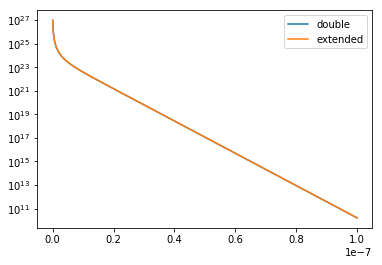

In [7]:
for t in types:
    o = b.output(0., sol[t], 0. * sol[t], params)
    plt.plot(
        b.poisson.mesh.cells['center'],
        np.abs(
            o['hole.c']),
        label=typename[t])
plt.yscale('log')
plt.legend(loc=0)

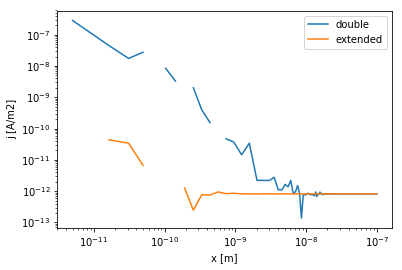

In [8]:
for t in types:
    o = b.output(0., sol[t], 0. * sol[t], params)
    plt.plot(
        b.poisson.mesh.faces['center'],
        np.abs(
            o['hole.j'] *
            b.species[0].ze),
        label=typename[t])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('x [m]')
plt.ylabel('j [A/m2]')
plt.legend(loc=0)


---
This file is a part of __oedes__, an open source organic electronic device 
simulator. For more information, see <https://www.github.com/mzszym/oedes>.
